In [1]:
import matplotlib.pyplot as plt
import helper_functions as helper
import numpy as np

In [17]:
import pandas as pd
from datetime import datetime

# Load the burst data from CSV
burst_data = pd.read_csv("/mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/compiledNetworkData.csv")

# Function to parse the recording date and calculate DIV from DIV 0
def parse_filename(filename, div0_date):
    parts = filename.split('/')
    run_id = parts[5][3:]  # Extract after 'run'
    well = parts[6]  # Part of the filename containing the well info
    chip_id = parts[3]
    day_of_recording = datetime.strptime(parts[2], "%y%m%d")
    div = (day_of_recording - div0_date).days

    # Extract the well number, add checks for format
    if well.startswith('well'):
        well_number = int(well[4:]) + 1  # Convert from index 4 onward
    else:
        raise ValueError(f"Unexpected well format: {well}")

    return pd.Series([run_id, str(div), str(well_number), chip_id], index=['Run_ID', 'DIV', 'Well', 'Chip_ID'])

# Input for the DIV 0 date
div0_input = '05212024'
div0_date = datetime.strptime(div0_input, "%m%d%Y")

# Apply the function to parse filenames, using DIV 0 date
burst_data[['Run_ID', 'DIV', 'Well', 'Chip_ID']] = burst_data['fileName'].apply(lambda x: parse_filename(x, div0_date))

# Load the reference data from Excel
ref_data = pd.read_excel("/mnt/disk20tb/PrimaryNeuronData/Maxtwo/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/Reffile.xlsx")

# Expand the reference data to match each well with its corresponding neuron type
expanded_ref_data = []
for _, row in ref_data.iterrows():
    wells = map(str.strip, row['Wells_Recorded'].split(','))
    neuron_types = row['Neuron Source'].split(', ')
    for well, neuron_type in zip(wells, neuron_types):
        expanded_ref_data.append({
            'Run_ID': str(row['Run #']),
            'Chip_ID': row['ID'],
            'Well': well,
            'Neuron Type': neuron_type,
            'Assay': row['Assay'],
            'DIV': str(row['Div'])  # Ensure DIV is string if mixed types might occur
        })

expanded_ref_df = pd.DataFrame(expanded_ref_data)
expanded_ref_df.to_csv("expanded_ref.csv",index=)
# Ensure data types are consistent for merging
columns_to_convert = ['Run_ID', 'DIV', 'Well', 'Chip_ID']
for col in columns_to_convert:
    burst_data[col] = burst_data[col].astype(str)
    expanded_ref_df[col] = expanded_ref_df[col].astype(str)

# Merge the burst data with the expanded reference data
final_data = pd.merge(burst_data, expanded_ref_df, on=['Run_ID', 'Chip_ID', 'Well'])

# Save the final combined dataset to a new CSV
final_data.to_csv("final_combined_data.csv", index=False)

# Display the first few rows of the final dataframe
print(final_data.head())

  Run_ID Chip_ID Well Neuron Type     Assay DIV
0      1  M07305    1        MxWT  Sparse7x   5
1      1  M07305    2        MxWT  Sparse7x   5
2      1  M07305    3        MxWT  Sparse7x   5
3      1  M07305    4       FxHET  Sparse7x   5
4      1  M07305    5       FxHET  Sparse7x   5
   Number_Bursts  mean_IBI    cov_IBI  mean_Burst_Peak  mean_Burst_Duration   
0             47  6.423913  13.621860         7.720282             0.721915  \
1             46  6.493333  18.207000         7.530814             0.668045   
2             47  6.100000  14.283111         6.802488             0.690428   
3            105  2.835577   1.595324         5.603177             0.789763   
4            128  2.306299   0.884087         5.182818             0.682872   

   cov_Burst_Peak  fano_factor  MeanWithinBurstISI  CoVWithinBurstISI   
0       13.379908  2582.859903            0.042239           0.000554  \
1        7.130236  1643.286943            0.043968           0.000630   
2        3.038031 

In [ ]:
import pandas as pd
from datetime import datetime

# Load the CSV file
data = pd.read_csv("your_data.csv")

# Function to parse the filename and calculate DIV
def parse_filename(filename, div0_date):
    parts = filename.split('/')
    cellline_day_chip = parts[0].split('_')
    day_of_recording = cellline_day_chip[2]
    div = (datetime.strptime(day_of_recording, "%d%m%y") - datetime.strptime(div0_date, "%d%m%y")).days
    return {
        "Run_ID": parts[5],
        "DIV": div,
        "Well": parts[6],
        "Chip_ID": parts[3]
    }

# Ask user for the DIV 0 date
div0_date = ''

# Apply parsing function to the filename column
data[['Run_ID', 'DIV', 'Well', 'Chip_ID']] = data['fileName'].apply(lambda x: pd.Series(parse_filename(x, div0_date)))

# Load the .xlsx file containing NeuronType
neuron_data = pd.read_excel("your_neuron_data.xlsx")

# Merge data on Run_ID, Chip_ID, and Well to find NeuronType
final_data = pd.merge(data, neuron_data, on=["Run_ID", "Chip_ID", "Well"])

# Save the combined data to a new CSV file
final_data.to_csv("final_output.csv", index=False)

dict_keys(['prominences', 'left_bases', 'right_bases'])


(0.0, 60.0)

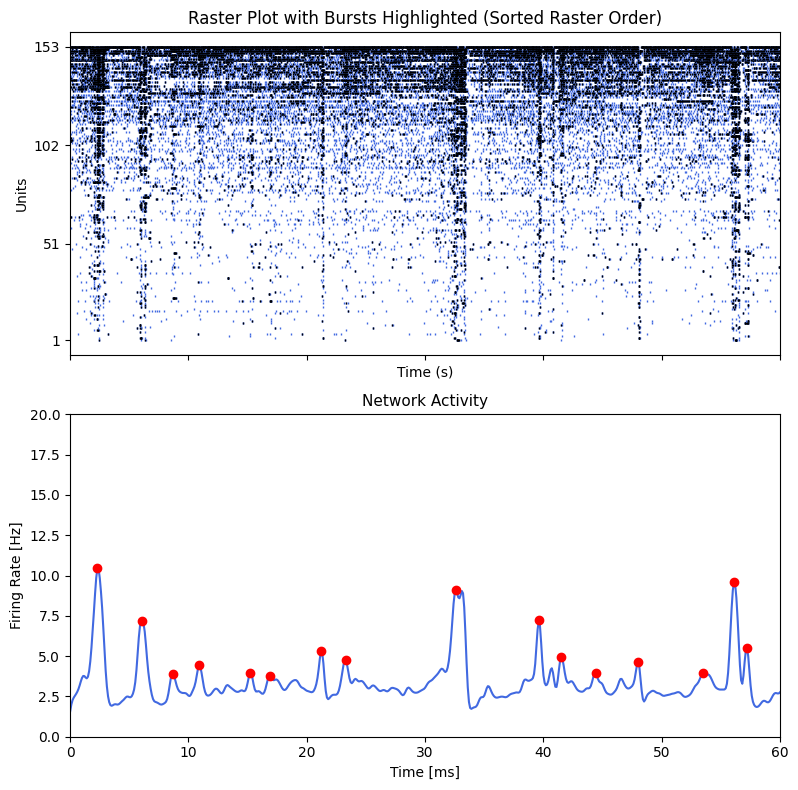

In [4]:
spike_times = np.load('/mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240611/M08029/Network/000091/well000/spike_times.npy', allow_pickle=True).item()

fig, axs = plt.subplots(2, 1, figsize=(8, 8),sharex=True)
# Define the ISI threshold for burst detection (e.g., 0.1 seconds)
isi_threshold = 0.1
# Detect bursts for each unit
burst_statistics = helper.detect_bursts_statistics(spike_times, isi_threshold)
bursts = [unit_stats['bursts'] for unit_stats in burst_statistics.values()]

# Calculate spike counts for each unit
spike_counts = {unit: len(times) for unit, times in spike_times.items()}

# Sort units by ascending spike counts
sorted_units = sorted(spike_counts, key=spike_counts.get)

axs[0]= helper.plot_raster_with_bursts(axs[0],spike_times, bursts,sorted_units=sorted_units, title_suffix="(Sorted Raster Order)")

# Call the plot_network_activity function and pass the SpikeTimes dictionary
axs[1],network_data= helper.plot_network_activity(axs[1],spike_times, figSize=(8, 4),binSize=0.1, gaussianSigma=0.2,min_peak_distance=10, thresholdBurst=2)
axs[1].set_ylim(0,20)
plt.tight_layout()
plt.xlim(0, 60)
#plt.savefig('/mnt/disk15tb/mmpatil/MEA_Analysis_dev/AnalyzedData/KCNT1_T3_C1_03122024/KCNT1_T3_C1_03122024/240402/M07037/Network/000064/well002/sorted_raster_WT_network.svg', format='svg')



In [5]:
import json
import numpy as np
import math
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, find_peaks
from scipy.stats import norm

In [6]:
min_peak_distance=1.0
binSize=0.1
gaussianSigma=0.16
thresholdBurst=1.2

relativeSpikeTimes = []
units = 0
for unit_id, spike_times in spike_times.items():
    relativeSpikeTimes.extend(spike_times) 
    units += 1 # Set the first spike time to 0

relativeSpikeTimes = np.array(relativeSpikeTimes)
relativeSpikeTimes.sort() # Convert to NumPy array

# Step 1: Bin all spike times into small time windows
timeVector = np.arange(min(relativeSpikeTimes), max(relativeSpikeTimes), binSize)  # Time vector for binning
binnedTimes, _ = np.histogram(relativeSpikeTimes, bins=timeVector)  # Bin spike times
binnedTimes = np.append(binnedTimes, 0)  # Append 0 to match MATLAB's binnedTimes length

# Step 2: Smooth the binned spike times with a Gaussian kernel
kernelRange = np.arange(-3*gaussianSigma, 3*gaussianSigma + binSize, binSize)  # Range for Gaussian kernel
kernel = norm.pdf(kernelRange, 0, gaussianSigma)  # Gaussian kernel
kernel *= binSize  # Normalize kernel by bin size
firingRate = convolve(binnedTimes, kernel, mode='same') / binSize  # Convolve and normalize by bin size
firingRate = firingRate / units  # Convert to Hz
peaks, properties = find_peaks(firingRate, prominence=1, distance=min_peak_distance)  # Find peaks above the threshold
#print(properties.keys())
burstPeakTimes = timeVector[peaks]  # Convert peak indices to times
#burstPeakValues = properties['prominences']  # Get the peak values
burstPeakValues = firingRate[peaks]  # Get the peak values

# Calculate the derivative
derivative = np.diff(firingRate)
derivative = np.append(derivative, 0)  # Match length with the signal

# Identify zero crossings
zero_crossings = np.where(np.diff(np.sign(derivative)))[0]

# Calculate widths using zero crossings
widths = []
for peak in peaks:
    # Find the nearest zero crossings before and after the peak
    left_zero = zero_crossings[zero_crossings < peak][-1]
    right_zero = zero_crossings[zero_crossings > peak][0]
    width = right_zero - left_zero
    widths.append(width)


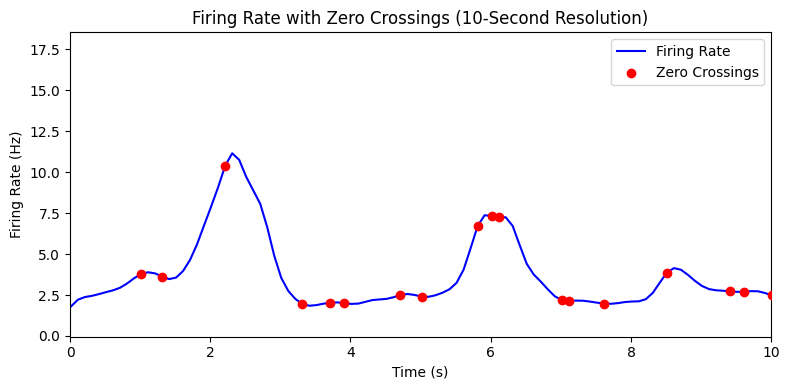

In [10]:
# Plot zero crossings with finer resolution for 10 seconds
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the firing rate
ax.plot(timeVector, firingRate, label='Firing Rate', color='blue')

# Mark the zero crossings
ax.scatter(timeVector[zero_crossings], firingRate[zero_crossings], color='red', label='Zero Crossings', zorder=5)

# Focus on a 10-second window
start_time = 0  # Adjust this to the desired start time
end_time = start_time + 10  # 10-second window
ax.set_xlim(start_time, end_time)

# Add labels and legend
ax.set_title('Firing Rate with Zero Crossings (10-Second Resolution)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Firing Rate (Hz)')
ax.legend()
plt.tight_layout()
plt.show()

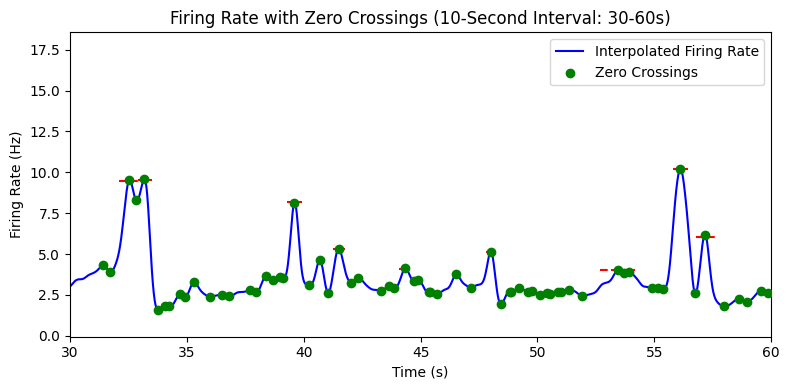

In [13]:
from scipy.interpolate import interp1d

# Interpolate the firing rate for finer resolution
interp_func = interp1d(timeVector, firingRate, kind='cubic')
fine_time_vector = np.linspace(timeVector[0], timeVector[-1], len(timeVector) * 10)
fine_firing_rate = interp_func(fine_time_vector)

# Calculate the derivative of the interpolated signal
fine_derivative = np.diff(fine_firing_rate)
fine_derivative = np.append(fine_derivative, 0)  # Match lengths

# Find zero crossings on the interpolated signal
fine_zero_crossings = np.where(np.diff(np.sign(fine_derivative)))[0]

# Calculate widths for each peak
fine_widths = []
for peak in peaks:
    # Find the nearest zero crossings before and after the peak
    peak_idx = np.argmin(np.abs(fine_time_vector - timeVector[peak]))  # Match peak to fine resolution
    left_zeros = fine_zero_crossings[fine_zero_crossings < peak_idx]
    right_zeros = fine_zero_crossings[fine_zero_crossings > peak_idx]

    if len(left_zeros) > 0 and len(right_zeros) > 0:
        left_zero = left_zeros[-1]
        right_zero = right_zeros[0]
        width = fine_time_vector[right_zero] - fine_time_vector[left_zero]
        fine_widths.append(width)

# Plot the results for a 10-second interval
start_time = 30 # Define the starting point of the 10-second interval
end_time = start_time + 30

fig, ax = plt.subplots(figsize=(8, 4))

# Plot the firing rate and its interpolation
ax.plot(fine_time_vector, fine_firing_rate, label='Interpolated Firing Rate', color='blue')

# Focus on the 10-second interval
ax.set_xlim(start_time, end_time)

# Mark zero crossings within the interval
filtered_zero_crossings = fine_zero_crossings[(fine_time_vector[fine_zero_crossings] >= start_time) &
                                              (fine_time_vector[fine_zero_crossings] <= end_time)]
ax.scatter(fine_time_vector[filtered_zero_crossings], 
           fine_firing_rate[filtered_zero_crossings], 
           color='green', label='Zero Crossings', zorder=5)

# Highlight peaks and their widths within the interval
for i, peak in enumerate(peaks):
    peak_idx = np.argmin(np.abs(fine_time_vector - timeVector[peak]))
    peak_time = fine_time_vector[peak_idx]
    if start_time <= peak_time <= end_time and i < len(fine_widths):  # Ensure peak and width exist in the interval
        width = fine_widths[i]
        ax.hlines(fine_firing_rate[peak_idx], 
                  peak_time - width / 2, 
                  peak_time + width / 2, 
                  color='red', linestyle='--', label='Width' if i == 0 else None)

# Add labels and legend
ax.set_title(f'Firing Rate with Zero Crossings (10-Second Interval: {start_time}-{end_time}s)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Firing Rate (Hz)')
ax.legend()
plt.tight_layout()
plt.show()

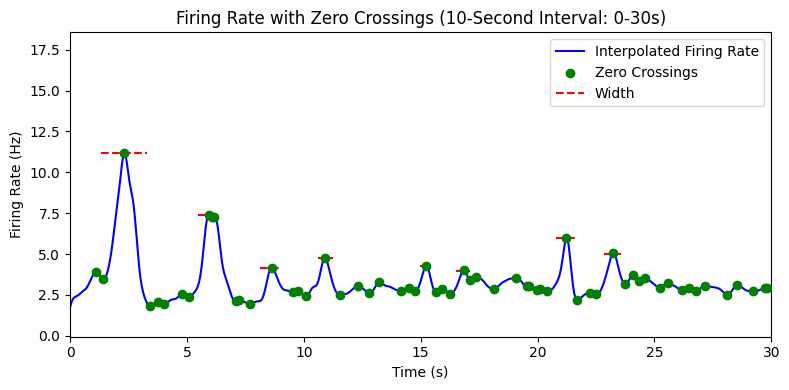

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, convolve
from scipy.stats import norm
from scipy.interpolate import interp1d

# Load spike times
spike_times = np.load('/mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240611/M08029/Network/000091/well000/spike_times.npy', allow_pickle=True).item()

# Consolidate all spike times
relativeSpikeTimes = []
units = 0
for unit_id, unit_spikes in spike_times.items():
    relativeSpikeTimes.extend(unit_spikes)
    units += 1

relativeSpikeTimes = np.array(relativeSpikeTimes)
relativeSpikeTimes.sort()

# Parameters
binSize = 0.1
gaussianSigma = 0.16
min_peak_distance = 1.0

# Step 1: Bin all spike times
timeVector = np.arange(min(relativeSpikeTimes), max(relativeSpikeTimes), binSize)
binnedTimes, _ = np.histogram(relativeSpikeTimes, bins=timeVector)
binnedTimes = np.append(binnedTimes, 0)  # Match lengths

# Step 2: Smooth the binned spike times with a Gaussian kernel
kernelRange = np.arange(-3 * gaussianSigma, 3 * gaussianSigma + binSize, binSize)
kernel = norm.pdf(kernelRange, 0, gaussianSigma)
kernel *= binSize  # Normalize kernel
firingRate = convolve(binnedTimes, kernel, mode='same') / binSize
firingRate = firingRate / units  # Convert to Hz

# Step 3: Find peaks
peaks, properties = find_peaks(firingRate, prominence=1, distance=min_peak_distance)

# Step 4: Interpolate for finer resolution
interp_func = interp1d(timeVector, firingRate, kind='cubic')
fine_time_vector = np.linspace(timeVector[0], timeVector[-1], len(timeVector) * 10)
fine_firing_rate = interp_func(fine_time_vector)

# Step 5: Calculate zero crossings
fine_derivative = np.diff(fine_firing_rate)
fine_derivative = np.append(fine_derivative, 0)
fine_zero_crossings = np.where(np.diff(np.sign(fine_derivative)))[0]

# Step 6: Calculate widths for each peak
fine_widths = []
for peak in peaks:
    peak_idx = np.argmin(np.abs(fine_time_vector - timeVector[peak]))
    left_zeros = fine_zero_crossings[fine_zero_crossings < peak_idx]
    right_zeros = fine_zero_crossings[fine_zero_crossings > peak_idx]

    if len(left_zeros) > 0 and len(right_zeros) > 0:
        left_zero = left_zeros[-1]
        right_zero = right_zeros[0]
        width = fine_time_vector[right_zero] - fine_time_vector[left_zero]
        fine_widths.append(width)

# Step 7: Visualize peaks and widths for a 10-second interval
start_time = 0  # Define the starting point of the interval
end_time = start_time + 30

fig, ax = plt.subplots(figsize=(8, 4))

# Plot the interpolated firing rate
ax.plot(fine_time_vector, fine_firing_rate, label='Interpolated Firing Rate', color='blue')

# Focus on the 10-second interval
ax.set_xlim(start_time, end_time)

# Mark zero crossings
filtered_zero_crossings = fine_zero_crossings[(fine_time_vector[fine_zero_crossings] >= start_time) &
                                              (fine_time_vector[fine_zero_crossings] <= end_time)]
ax.scatter(fine_time_vector[filtered_zero_crossings],
           fine_firing_rate[filtered_zero_crossings],
           color='green', label='Zero Crossings', zorder=5)

# Highlight peaks and their widths within the interval
for i, peak in enumerate(peaks):
    peak_idx = np.argmin(np.abs(fine_time_vector - timeVector[peak]))
    peak_time = fine_time_vector[peak_idx]
    if start_time <= peak_time <= end_time and i < len(fine_widths):
        width = fine_widths[i]
        ax.hlines(fine_firing_rate[peak_idx],
                  peak_time - width / 2,
                  peak_time + width / 2,
                  color='red', linestyle='--', label='Width' if i == 0 else None)

# Add labels and legend
ax.set_title(f'Firing Rate with Zero Crossings (10-Second Interval: {start_time}-{end_time}s)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Firing Rate (Hz)')
ax.legend()
plt.tight_layout()
plt.show()

In [27]:
import os
import csv
import numpy as np
from scipy.signal import find_peaks, convolve
from scipy.stats import norm
from scipy.interpolate import interp1d

def calculate_mean_widths(spike_times_file, binSize=0.1, gaussianSigma=0.16, min_peak_distance=1.0):
    """
    Calculate the mean peak widths for the given spike times file.
    """
    # Load spike times
    spike_times = np.load(spike_times_file, allow_pickle=True)

    # Check the structure of spike_times and handle accordingly
    if isinstance(spike_times, dict):  # If the file contains a dictionary-like object
        spike_times = spike_times
    elif isinstance(spike_times, np.ndarray):  # If the file contains an array
        spike_times = spike_times.item()  # Try converting it to a dictionary-like object
    else:
        raise ValueError(f"Unexpected format in file: {spike_times_file}")

    # Consolidate all spike times
    relativeSpikeTimes = []
    units = 0
    for unit_id, unit_spikes in spike_times.items():
        relativeSpikeTimes.extend(unit_spikes)
        units += 1

    relativeSpikeTimes = np.array(relativeSpikeTimes)
    relativeSpikeTimes.sort()

    # Step 1: Bin all spike times
    timeVector = np.arange(min(relativeSpikeTimes), max(relativeSpikeTimes), binSize)
    binnedTimes, _ = np.histogram(relativeSpikeTimes, bins=timeVector)
    binnedTimes = np.append(binnedTimes, 0)  # Match lengths

    # Step 2: Smooth the binned spike times with a Gaussian kernel
    kernelRange = np.arange(-3 * gaussianSigma, 3 * gaussianSigma + binSize, binSize)
    kernel = norm.pdf(kernelRange, 0, gaussianSigma)
    kernel *= binSize  # Normalize kernel
    firingRate = convolve(binnedTimes, kernel, mode='same') / binSize
    firingRate = firingRate / units  # Convert to Hz

    # Step 3: Find peaks
    peaks, _ = find_peaks(firingRate, prominence=1, distance=min_peak_distance)

    # Step 4: Interpolate for finer resolution
    interp_func = interp1d(timeVector, firingRate, kind='cubic')
    fine_time_vector = np.linspace(timeVector[0], timeVector[-1], len(timeVector) * 10)
    fine_firing_rate = interp_func(fine_time_vector)

    # Step 5: Calculate zero crossings
    fine_derivative = np.diff(fine_firing_rate)
    fine_derivative = np.append(fine_derivative, 0)
    fine_zero_crossings = np.where(np.diff(np.sign(fine_derivative)))[0]

    # Step 6: Calculate widths for each peak
    fine_widths = []
    for peak in peaks:
        peak_idx = np.argmin(np.abs(fine_time_vector - timeVector[peak]))
        left_zeros = fine_zero_crossings[fine_zero_crossings < peak_idx]
        right_zeros = fine_zero_crossings[fine_zero_crossings > peak_idx]

        if len(left_zeros) > 0 and len(right_zeros) > 0:
            left_zero = left_zeros[-1]
            right_zero = right_zeros[0]
            width = fine_time_vector[right_zero] - fine_time_vector[left_zero]
            fine_widths.append(width)

    # Calculate mean width
    return np.mean(fine_widths) if fine_widths else None

def recursive_mean_widths(directory, output_csv):
    """
    Recursively traverse the directory to find all spike_times.npy files,
    calculate the mean peak widths, and save the results in a CSV.
    """
    results = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'spike_times.npy':
                # Skip spike_times.npy files inside subdirectories like "kilosort2__rec0000"
                if 'kilosort' in root.lower():
                    print(f"Skipping: {os.path.join(root, file)}")
                    continue

                file_path = os.path.join(root, file)
                print(f"Processing: {file_path}")
                mean_width = calculate_mean_widths(file_path)
                results.append({'filename': file_path, 'mean_width': mean_width})

    # Save results to CSV
    with open(output_csv, mode='w', newline='') as csvfile:
        fieldnames = ['filename', 'mean_width']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        writer.writerows(results)

    print(f"Results saved to {output_csv}")


# Parent directory to search
parent_directory = "/mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/"

# Output CSV file
output_csv = "mean_widths_results.csv"

# Recursively calculate mean widths and save to CSV
recursive_mean_widths(parent_directory, output_csv)

Processing: /mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240614/M08029/Network/000105/well003/spike_times.npy
Skipping: /mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240614/M08029/Network/000105/well003/kilosort2__rec0000/sorter_output/spike_times.npy
Processing: /mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240614/M08029/Network/000105/well001/spike_times.npy
Skipping: /mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240614/M08029/Network/000105/well001/kilosort2__rec0000/sorter_output/spike_times.npy
Processing: /mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240614/M08029/Network/000105/well002/spike_times.npy
Skipping: /mnt/disk15tb/mmpatil/MEA_Analysis_New/AnalyzedData/CDKL5-E6D_T2_C1/CDKL5-E6D_T2_C1/240614/M08029/Network/000105/well002/kilosort2__rec0000/sorter_output/spike_times.npy
Processing: /

In [16]:
fine_widths

[1.9993999799993338,
 0.859741991399714,
 0.9397179905996875,
 0.6398079935997867,
 0.48985299509983626,
 0.5698289942998116,
 0.8297509916997221,
 0.7397779925997554,
 0.8297509916997257,
 0.589822994099805,
 0.6298109936997847,
 0.359891996399881,
 0.5498349944998182,
 0.45986199539984796,
 0.42987099569985787,
 1.5195439847994905,
 0.6398079935997885,
 0.8397479915997152,
 0.6198139937997951,
 0.5098469948998314,
 0.8597419913997157,
 0.45986199539984796,
 0.49984999499983473,
 0.7497749924997521,
 0.1999399979999339,
 0.8297509916997114,
 1.4195739857995306,
 1.1496549884996057,
 0.45986199539984796,
 0.3398979965998876,
 0.529840994699839,
 0.7597719923997488,
 0.7097869928997511,
 0.27991599719990745,
 1.369588986299533,
 0.9497149904996718,
 0.5598319943998149,
 0.4198739957998612,
 1.2296309876995792,
 0.2099369978999448,
 0.6897929930997577,
 0.8097569918997181,
 0.3498949964998985,
 0.49984999499983473,
 0.9996999899996695,
 0.44986499549983705,
 0.5598319943998149,
 0.419873

In [17]:
from scipy.signal import peak_widths

widths, height, left_ips, right_ips = peak_widths(firingRate, peaks, rel_height=0.5)

In [19]:
widths/10

array([0.93402251, 0.8297938 , 0.52294578, 0.49078347, 0.42720857,
       1.04887175, 0.44750541, 0.59719135, 0.26474573, 1.27659351,
       0.47527238, 0.32641336, 0.49958011, 0.51168269, 0.39007508,
       1.12755599, 0.72091518, 0.39965618, 1.32512462, 0.54854401,
       0.68901751, 0.67809831, 2.34037755, 0.59937963, 0.8837249 ,
       0.51119619, 0.37281056, 0.70538242, 0.71687589, 1.87964506,
       0.53030059, 0.99430676, 2.70249474, 0.25141867, 0.85666701,
       0.42986979, 0.48450411, 0.50998552, 0.67319896, 1.19073537,
       0.6036495 , 0.55499865, 0.5470789 , 0.46711724, 0.402924  ,
       2.3255975 , 0.33216062, 0.42193674, 0.9801557 , 1.08706446,
       1.26600894, 1.52893627, 0.51935711, 0.89961556, 1.09162173,
       0.64129564, 1.42060958, 0.46325383, 0.20527953, 1.53549876,
       0.41849835, 0.51608985, 0.36396373, 0.57087109, 0.4195247 ,
       0.73645629, 0.82014567, 5.84640757])

In [8]:
spike_times = np.load('/mnt/disk15tb/mmpatil/MEA_Analysis_dev/AnalyzedData/KCNT1_T3_C1_03122024/KCNT1_T3_C1_03122024/240402/M07037/Network/000064/well001/spike_times.npy', allow_pickle=True).item()
print(spike_times)

{0: array([  0.8914,   1.0375,   1.0532,   3.967 ,   3.9728,   3.9797,
         3.9858,   4.7374,   4.7522,   6.2088,   7.5188,   7.5232,
         8.8974,   8.9014,  10.055 ,  10.4726,  10.8391,  10.9788,
        14.9626,  14.9677,  16.228 ,  16.6363,  16.6477,  16.6518,
        17.4681,  18.942 ,  19.9129,  20.8529,  22.278 ,  25.4962,
        25.6796,  27.1994,  27.2645,  27.2681,  27.5054,  27.8246,
        27.8331,  27.8787,  28.8617,  28.8743,  28.9295,  28.9365,
        31.5375,  32.533 ,  32.5365,  32.5682,  35.7047,  35.7088,
        36.985 ,  38.352 ,  38.3561,  39.5454,  40.4211,  40.4249,
        42.0859,  42.1092,  42.1588,  42.189 ,  42.2073,  42.2439,
        42.274 ,  45.0223,  46.041 ,  46.0757,  47.4723,  47.4812,
        47.4863,  48.5787,  48.5887,  49.4005,  49.518 ,  52.4066,
        52.4203,  52.9597,  54.1103,  54.1144,  58.6864,  60.1192,
        61.5001,  61.7852,  63.5036,  63.5202,  64.9242,  65.1759,
        69.3072,  69.9945,  70.0448,  70.0555,  71.1722,  